In [1]:
%matplotlib notebook
# does not work in colab
! pip install ffmpeg

## Mandelbrot set

 Mandelbrot set is the set of values of c for which <br>
$ z_{n+1} = z_{n}^{2} + c $ &emsp; remains bounded

More specifically, a point $c$ belongs to the Mandelbrot set if and only if  <br>
$|z_{n}|\leq 2$ &emsp; for all &emsp; $n\geq 0$

More information can be found here:
- https://en.wikipedia.org/wiki/Mandelbrot_set

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from tqdm.notebook import tqdm
import time
from matplotlib.animation import FuncAnimation, FFMpegWriter

### define parameters

In [3]:
# define size
# using top left and bottom right coordinates
img_size = ((0,0),(600,400))
frac_size = ((-2,-1),(1,1))
(frac_x0,frac_y0), (frac_x1,frac_y1) = frac_size
(img_x0,img_y0), (img_x1,img_y1) = img_size
img_w = img_x1 - img_x0
img_h = img_y1 - img_y0

# define parameters
maxIter = 100
frac_xStep = (frac_x1-frac_x0)/(img_x1-img_x0)
frac_yStep = (frac_y1-frac_y0)/(img_y1-img_y0)
params = {"maxIter":maxIter, "frac_xStep":frac_xStep, "frac_yStep":frac_yStep}    

### plot fractal

In [4]:
def imgToFrac(frac_size,img_size,point):
  (frac_x0,frac_y0), (frac_x1,frac_y1) = frac_size
  (img_x0,img_y0), (img_x1,img_y1) = img_size
  img_x1 -= 1.0;  img_y1 -= 1.0

  x0, y0 = point
  x1 = (x0-img_x0)*(frac_x1-frac_x0)/(img_x1-img_x0) + frac_x0
  y1 = (y0-img_y0)*(frac_y0-frac_y1)/(img_y1-img_y0) + frac_y1
  return x1,y1

def fracToImg(frac_size,img_size,point):
  (frac_x0,frac_y0), (frac_x1,frac_y1) = frac_size
  (img_x0,img_y0), (img_x1,img_y1) = img_size
  img_x1 -= 1;  img_y1 -= 1

  x0, y0 = point
  x1 = int(round((x0-frac_x0)*(img_x1-img_x0)/(frac_x1-frac_x0) + img_x0))
  y1 = int(round((y0-frac_y0)*(img_y0-img_y1)/(frac_y1-frac_y0) + img_y1))
  return x1,y1

def plot_frac(frac_size,img_size,params):

  (frac_x0,frac_y0), (frac_x1,frac_y1) = frac_size
  (img_x0,img_y0), (img_x1,img_y1) = img_size
  img_w = img_x1 - img_x0
  img_h = img_y1 - img_y0

  img = np.zeros((img_h, img_w, 3))   # create a blank np array to hold the image
  for x in tqdm(np.arange(frac_x0, frac_x1+params["frac_xStep"], params["frac_xStep"])):    # have added step size to endpoints to include them
    for y in np.arange(frac_y0, frac_y1+params["frac_xStep"], params["frac_yStep"]):
      
      c = x+y*1j
      z = c

      for i in range(params["maxIter"]):
        z = z**2 + c
        if abs(z) > 2:
            break
      # color depends on the number of maxIter
      h = i/(params["maxIter"] - 1)
      s = 1
      v = 1 - i/(params["maxIter"]-1)  # points taking longer to converge should appear darker (more black)
      # assign in np array
      i,j = fracToImg(frac_size,img_size,(x, y))
      img[j][i] = np.array([h,s,v])
  
  return hsv_to_rgb(img)

In [5]:
img = plot_frac(frac_size,img_size,params)
# plt.imshow(img);  plt.show()

add axes

<IPython.core.display.Javascript object>


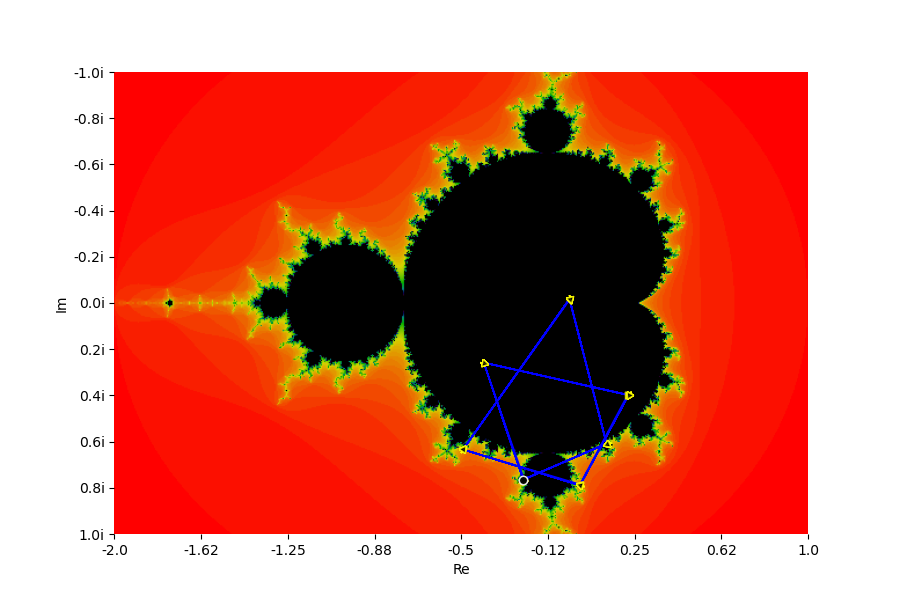

In [6]:
def show_img(ax,img):
    ax.imshow(img)
    xlen = len(ax.get_xticks())
    ylen = len(ax.get_yticks())
    xlen += (xlen+1)%2; ylen += (ylen+1)%2
    xticks = np.linspace(img_x0,img_x1-1,xlen)
    yticks = np.linspace(img_y0,img_y1-1,ylen)
    xlabels = np.round(np.linspace(frac_x0,frac_x1,xlen),2)
    ylabels = np.round(np.linspace(frac_y1,frac_y0,ylen),2)
    ylabels = [str(l)+'i' for l in ylabels]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel("Re")
    ax.set_ylabel("Im")
    ax.set_frame_on(False)
    ax.set_xlim([img_x0,img_x1-1])
    ax.set_ylim([img_y0,img_y1-1])






fig, ax = plt.subplots(1, figsize=(9,6))
show_img(ax,img)
line1, = ax.plot([0],[0], linewidth=1, color="blue")  # to be used for lines
lines = []  # to be used for arrows
for _ in range(params["maxIter"]):
    line2, = ax.plot([0],[0], alpha=0.8)
    line3, = ax.plot([0],[0], alpha=0.8)
    lines.append((line2, line3))
text = ax.text(0,0, "", va="bottom", ha="left")

def mouse_move(event):
    x, y = event.xdata, event.ydata  
    
    t_ms = time.time()*10 % 10
    if t_ms > 0.0:  # increase to reduce plot update rate
        
        #ax.cla()
        #show_img(ax,img)        
        x, y = imgToFrac(frac_size,img_size,(x, y))

        orbit = []

        c = x + y*1j
        z = c
        for i in range(params["maxIter"]):
            orbit.append(fracToImg(frac_size,img_size,(z.real, z.imag)))
            z = z**2 + c
            if abs(z) > 2:
                break

        x,y = np.array(list(zip(*orbit)))
        line1.set_xdata(x)
        line1.set_ydata(y)
        #ax.plot(x,y)

        u = x[1:] - x[:-1]
        v = y[1:] - y[:-1]
        angles = np.arctan2(v[1:],u[1:]) * 180 / np.pi - 90
        
        for i in range(params["maxIter"]):
            line2, line3 = lines[i]
            if i < len(x) - 2:
              line2.set_xdata(x[i+1]); line3.set_xdata(x[i+1])
              line2.set_ydata(y[i+1]); line3.set_ydata(y[i+1])
              line2.set_marker((2,0,angles[i])); line3.set_marker((3,0,angles[i]))
              line2.set_markerfacecolor("black"); line3.set_markerfacecolor("black")
              line2.set_markeredgecolor("yellow"); line3.set_markeredgecolor("yellow")
            elif i == len(x) - 2:
              line2.set_xdata(x[i+1]); line3.set_xdata(x[i+1]);
              line2.set_ydata(y[i+1]); line3.set_ydata(y[i+1])
              line2.set_marker('o'); line3.set_marker('o')
              line2.set_markerfacecolor("black"); line3.set_markerfacecolor("black")
              line2.set_markeredgecolor("white"); line3.set_markeredgecolor("white")
            else:
              line2.set_xdata(0); line3.set_xdata(0)
              line2.set_ydata(0); line3.set_ydata(0)

        tx = "%s" % (angles[:3])
        #text.set_text(tx)
        #ax.quiver(x[:-1],y[:-1],u,v, scale_units='xy', angles='xy', scale=1, width=0.001, headwidth=10, color='blue')
        #ax.scatter(x[-1],y[-1], s=10)  # show the last point

        #fig.canvas.draw()
        #fig.canvas.flush_events()

cid = fig.canvas.mpl_connect('motion_notify_event', mouse_move)
#cid = fig.canvas.mpl_connect('button_press_event', mouse_move)

<IPython.core.display.Javascript object>


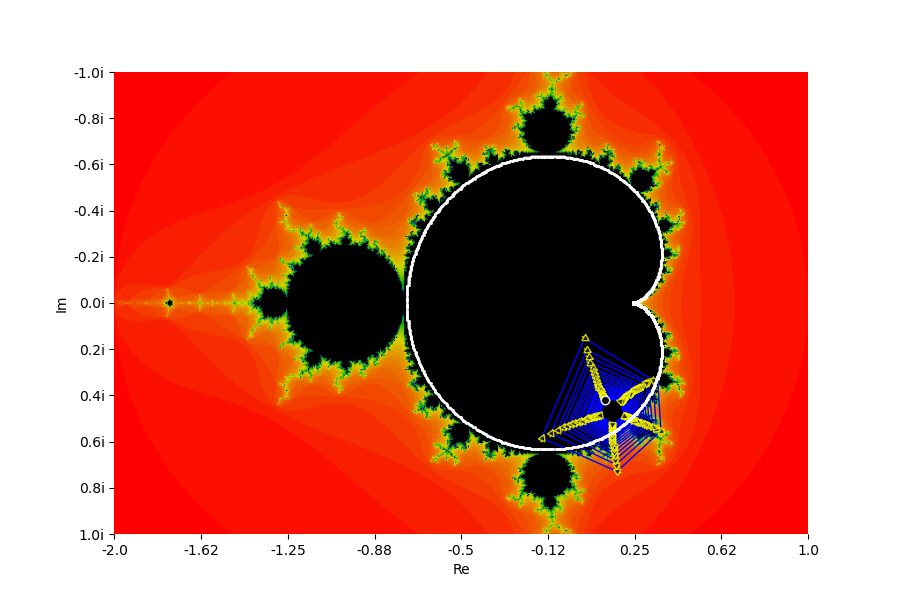

In [7]:
frames = 2000

# Init only required for blitting to give a clean slate.
def init():
    line1.set_data([],[])
    lines = []  # to be used for arrows
    for line in lines:
        line1.set_data([],[])
    line4.set_data([],[])
    return line1, lines, line4

# animation function 
def animate(i): 
    #ax.cla()
    #show_img(ax,img)   
    
    t = (i/frames)*2*np.pi
    c = (np.exp(t*1j)*(2-np.exp(t*1j))/4)*0.98  # slightly off the boundary of cardioid
    x,y = c.real, c.imag

    orbit = []

    c = x+y*1j
    z = c
    for i in range(params["maxIter"]):
        orbit.append(fracToImg(frac_size,img_size,(z.real, z.imag)))
        z = z**2 + c
        if abs(z) > 2:
            break

    x,y = np.array(list(zip(*orbit)))
    line1.set_data(x,y)
    #ax.plot(x,y)

    u = x[1:] - x[:-1]
    v = y[1:] - y[:-1]
    angles = np.arctan2(v[1:],u[1:]) * 180 / np.pi - 90

    for i in range(params["maxIter"]):
        line2, line3 = lines[i]
        if i < len(x) - 2:
          line2.set_data(x[i+1], y[i+1]); line3.set_data(x[i+1], y[i+1])
          line2.set_marker((2,0,angles[i])); line3.set_marker((3,0,angles[i]))
          line2.set_markerfacecolor("black"); line3.set_markerfacecolor("black")
          line2.set_markeredgecolor("yellow"); line3.set_markeredgecolor("yellow")
        elif i == len(x) - 2:    # show the last point as circle
          line2.set_data(x[i+1], y[i+1]); line3.set_data(x[i+1], y[i+1])
          line2.set_marker('o'); line3.set_marker('o')
          line2.set_markerfacecolor("black"); line3.set_markerfacecolor("black")
          line2.set_markeredgecolor("white"); line3.set_markeredgecolor("white")
        else:
          line2.set_data(0,0); line3.set_data(0,0)
            
    #ax.quiver(x[:-1],y[:-1],u,v, scale_units='xy', angles='xy', scale=1, width=0.001, headwidth=10, color='blue')
    points.append((x[0],y[0]))
    x,y = np.array(list(zip(*points)))
    line4.set_data(x,y)  # show first points of all frames
    
    return line1, lines, line4
    
    
fig, ax = plt.subplots(1, figsize=(9,6))
show_img(ax,img)
line1, = ax.plot([],[], linewidth=1, color="blue")  # to be used for lines
lines = []  # to be used for arrows
for _ in range(params["maxIter"]):
    line2, = ax.plot([],[], alpha=0.8)
    line3, = ax.plot([],[], alpha=0.8)
    lines.append((line2, line3))
line4, = ax.plot([],[], marker='o', markersize=1, color="white")  # to be used for initial point
points = []

# call the animator
anim = FuncAnimation(fig, animate, tqdm(range(frames), initial=1), init_func=init, blit=True)
anim.save('mandel.mp4', writer=FFMpegWriter(fps=20))